**Generating new pokemon using GAN** 


Submitted by Manpreet Singh

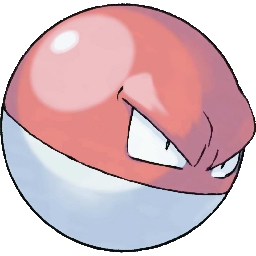

**Generating new pokemon using GAN.**

Agenda of This excercise is to getting familier with GAN networks and working with :-
1.   Discriminator
2.   Generator



The generator learns how to capture random noise and generate images that look like images from the training data. It does this by feeding the images it generates to a discriminator network, which is trained to distinguish between actual and generated images.

The generator is optimized to fool the discriminator better and better, and the discriminator is optimized to detect the generated image better and better. Therefore, they all progress together.

Firstly loading the necessary files.

Mount the dataset using google colab drive mount function.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid,save_image
import cv2
import PIL
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
cd /content/gdrive/My Drive/kaggle

/content/gdrive/My Drive/kaggle


In [ ]:
Path = "/content/gdrive/MyDrive/kaggle/archive/pokemon_jpg"
os.listdir(Path)

['pokemon_jpg']

Setting the image dimensions so that it is consistent and precise for the network to learn features.

Let's make a helper function that denormalizes the image tensor and shows some examples from the training batch.


In [ ]:
# setting the image size
image_size = 64
batch_size = 20
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(Path,transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats),
    tt.RandomHorizontalFlip(p=0.5)
]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:


def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]



We define a couple of helper functions (get default device & to device) and a helper class DeviceDataLoader to transport our model & data to the GPU, if one is available, in order to use it effortlessly.

In [ ]:


def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=5).permute(1, 2, 0))



In [ ]:


def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break



An example of a Pokemon batch is as follows:

Checking device type where model is being run.Your default device may be a CPU (torch.device('cpu')) or a GPU (torch.device('cuda') depending on where you're running this notebook.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


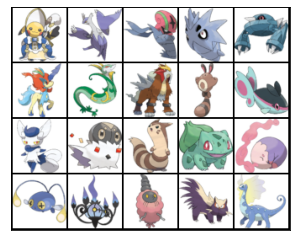

In [ ]:


show_batch(train_dl)



In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,device)
    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

**The Model**

We can now use DeviceDataLoader to automatically transport batches of data to the GPU with our training data loader (if available).

**Discriminator**

The discriminator model comes first. The following is the PyTorch implementation of the architecture that I found to be the most effective.

An image is fed into the discriminator, which attempts to classify it as "real" or "generated." It's similar to any other neural network in this regard. For each image, we'll utilize a convolutional neural network (CNN), which produces a single numerical output. To gradually lower the size of the output feature map, we'll use a stride of 2.


In [ ]:


discriminator = nn.Sequential(
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),
    
    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),
    
    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),
    
    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),
    
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    
    nn.Flatten(),
    nn.Sigmoid()
)



In [ ]:
discriminator = to_device(discriminator,device)

**Generator Network**

A vector or a matrix of random integers (referred to as a latent tensor) is often fed into the generator as a seed for creating a picture. A latent tensor of shape (e.g. 128, 1, 1) will be converted into an image tensor of shape 3 x 28 x 28 by the generator.To accomplish this, we'll use PyTorch's ConvTranspose2d layer, which acts as a transposed convolution (also referred to as a deconvolution).

In [ ]:
latent_size = 10
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size,512,kernel_size=4,stride=1,padding=0,bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias = False),
    nn.Tanh()
)

Print/Showing the fake image generated by generator.

torch.Size([20, 3, 64, 64])


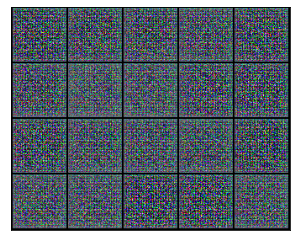

In [ ]:

#Noise 
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)



Because we haven't educated the generator yet, the output is just random noise.

Let's move the generator to the device we've decided on.

In [ ]:
generator = to_device(generator,device)

**Training discriminator.**

The steps to train the discriminator are outlined below.



*   The discriminator should return 1 if the image was taken
from the real dataset and 0 if it was created with the generator network.
*   We compute the loss after passing a batch of real photos, with the target labels set to 1.
*   Then we pass a batch of fictitious images (created with the generator) through the discriminator.
*   Finally, we combine the two losses and use the aggregate loss to update the discriminator's weights using gradient descent.





It's crucial to note that while training the discriminator, we don't change the weights of the generator model (opt d only impacts the discriminator.parameters())

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score


**Training Generator**

Because the generator's outputs are images, it's not clear how we can train it. This is where we use a clever method, which is to include the discriminator in the loss function. How it works is as follows:

We use the generator to generate a batch of photos, which we then feed into the discriminator. The loss is calculated by setting the target labels to 1, i.e. real.


In [ ]:


def train_generator(opt):
    opt.zero_grad()
    # noise 
    latent = torch.randn(batch_size,latent_size,1,1,device=device)
    #
    fake_images = generator(latent)
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size,1,device = device)
    loss = F.binary_cross_entropy(preds,targets)
    loss.backward()
    opt.step()
    return loss.item()
    



In [ ]:


sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)



In [ ]:


def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))



In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


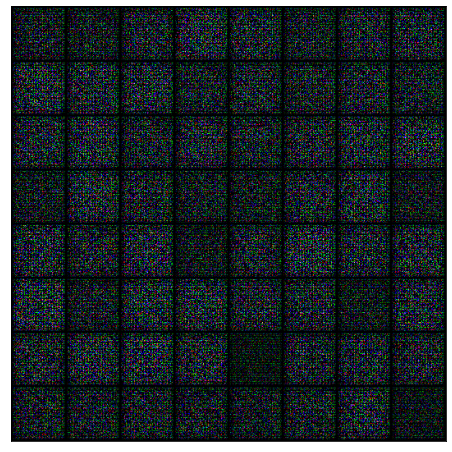

In [ ]:


save_samples(0, fixed_latent)



**Looped Training**

To train the discriminator and generator in tandem for each batch of training data, design a fit function. We'll utilize the Adam optimizer with some modified settings (betas) that have been shown to be effective for GANs. At regular intervals, we'll save some sample created photos for inspection.

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

The model is now ready to be trained. To check if you can keep the tight balance between training the generator and the discriminator, experiment with different learning rates

In [ ]:
lr = 0.0002
epochs = 1000
history = fit(epochs, lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [1/1000], loss_g: 7.4277, loss_d: 0.0238, real_score: 0.9959, fake_score: 0.0194
Saving generated-images-0001.png



Epoch [2/1000], loss_g: 17.2321, loss_d: 0.0005, real_score: 0.9995, fake_score: 0.0000
Saving generated-images-0002.png



Epoch [3/1000], loss_g: 6.1951, loss_d: 0.1350, real_score: 0.9333, fake_score: 0.0595
Saving generated-images-0003.png



Epoch [4/1000], loss_g: 1.8748, loss_d: 0.5194, real_score: 0.6542, fake_score: 0.0628
Saving generated-images-0004.png



Epoch [5/1000], loss_g: 0.7580, loss_d: 0.7199, real_score: 0.5269, fake_score: 0.0218
Saving generated-images-0005.png



Epoch [6/1000], loss_g: 2.0551, loss_d: 0.7664, real_score: 0.7372, fake_score: 0.3166
Saving generated-images-0006.png



Epoch [7/1000], loss_g: 6.3761, loss_d: 1.1523, real_score: 0.9543, fake_score: 0.6142
Saving generated-images-0007.png



Epoch [8/1000], loss_g: 5.0055, loss_d: 1.0166, real_score: 0.8677, fake_score: 0.5541
Saving generated-images-0008.png



Epoch [9/1000], loss_g: 2.0130, loss_d: 0.5533, real_score: 0.7785, fake_score: 0.2355
Saving generated-images-0009.png



Epoch [10/1000], loss_g: 3.0111, loss_d: 0.9309, real_score: 0.7504, fake_score: 0.4437
Saving generated-images-0010.png



Epoch [11/1000], loss_g: 0.6668, loss_d: 1.1221, real_score: 0.4697, fake_score: 0.1758
Saving generated-images-0011.png



Epoch [12/1000], loss_g: 1.2402, loss_d: 1.0755, real_score: 0.4060, fake_score: 0.0631
Saving generated-images-0012.png



Epoch [13/1000], loss_g: 4.2355, loss_d: 1.0982, real_score: 0.8803, fake_score: 0.5551
Saving generated-images-0013.png



Epoch [14/1000], loss_g: 2.8149, loss_d: 0.7030, real_score: 0.7563, fake_score: 0.3235
Saving generated-images-0014.png



Epoch [15/1000], loss_g: 1.5513, loss_d: 0.9693, real_score: 0.6751, fake_score: 0.3730
Saving generated-images-0015.png



Epoch [16/1000], loss_g: 3.4996, loss_d: 1.0858, real_score: 0.7158, fake_score: 0.4922
Saving generated-images-0016.png



Epoch [17/1000], loss_g: 4.1809, loss_d: 1.0928, real_score: 0.8722, fake_score: 0.5955
Saving generated-images-0017.png



Epoch [18/1000], loss_g: 2.2863, loss_d: 0.6219, real_score: 0.8528, fake_score: 0.3293
Saving generated-images-0018.png



Epoch [19/1000], loss_g: 3.5151, loss_d: 0.4372, real_score: 0.7851, fake_score: 0.1630
Saving generated-images-0019.png



Epoch [20/1000], loss_g: 2.4303, loss_d: 0.9116, real_score: 0.8250, fake_score: 0.4575
Saving generated-images-0020.png



Epoch [21/1000], loss_g: 3.5453, loss_d: 0.7163, real_score: 0.7571, fake_score: 0.3213
Saving generated-images-0021.png



Epoch [22/1000], loss_g: 2.8020, loss_d: 0.5169, real_score: 0.8181, fake_score: 0.2392
Saving generated-images-0022.png



Epoch [23/1000], loss_g: 1.8497, loss_d: 0.8091, real_score: 0.5501, fake_score: 0.1385
Saving generated-images-0023.png



Epoch [24/1000], loss_g: 5.4901, loss_d: 1.3498, real_score: 0.9498, fake_score: 0.6804
Saving generated-images-0024.png



Epoch [25/1000], loss_g: 0.9437, loss_d: 1.2993, real_score: 0.3564, fake_score: 0.1452
Saving generated-images-0025.png



Epoch [26/1000], loss_g: 3.1926, loss_d: 0.7082, real_score: 0.8534, fake_score: 0.3919
Saving generated-images-0026.png



Epoch [27/1000], loss_g: 2.0005, loss_d: 0.7684, real_score: 0.6046, fake_score: 0.1762
Saving generated-images-0027.png



Epoch [28/1000], loss_g: 3.1578, loss_d: 0.5494, real_score: 0.7901, fake_score: 0.2430
Saving generated-images-0028.png



Epoch [29/1000], loss_g: 1.7877, loss_d: 0.8197, real_score: 0.5134, fake_score: 0.0802
Saving generated-images-0029.png



Epoch [30/1000], loss_g: 2.4774, loss_d: 0.6707, real_score: 0.6962, fake_score: 0.2059
Saving generated-images-0030.png



Epoch [31/1000], loss_g: 3.9602, loss_d: 0.8170, real_score: 0.8753, fake_score: 0.4715
Saving generated-images-0031.png



Epoch [32/1000], loss_g: 2.7780, loss_d: 0.9754, real_score: 0.4484, fake_score: 0.0662
Saving generated-images-0032.png



Epoch [33/1000], loss_g: 2.2803, loss_d: 0.7794, real_score: 0.5956, fake_score: 0.1529
Saving generated-images-0033.png



Epoch [34/1000], loss_g: 2.6690, loss_d: 0.4632, real_score: 0.8160, fake_score: 0.2158
Saving generated-images-0034.png



Epoch [35/1000], loss_g: 3.1347, loss_d: 0.7220, real_score: 0.8044, fake_score: 0.3579
Saving generated-images-0035.png



Epoch [36/1000], loss_g: 2.5230, loss_d: 0.7965, real_score: 0.8277, fake_score: 0.4131
Saving generated-images-0036.png



Epoch [37/1000], loss_g: 2.0011, loss_d: 0.6140, real_score: 0.6497, fake_score: 0.1159
Saving generated-images-0037.png



Epoch [38/1000], loss_g: 1.9178, loss_d: 0.7656, real_score: 0.6734, fake_score: 0.2682
Saving generated-images-0038.png



Epoch [39/1000], loss_g: 1.1844, loss_d: 1.1431, real_score: 0.4373, fake_score: 0.1416
Saving generated-images-0039.png



Epoch [40/1000], loss_g: 1.1403, loss_d: 0.9487, real_score: 0.4521, fake_score: 0.0573
Saving generated-images-0040.png



Epoch [41/1000], loss_g: 2.2014, loss_d: 1.0497, real_score: 0.5174, fake_score: 0.2288
Saving generated-images-0041.png



Epoch [42/1000], loss_g: 1.9772, loss_d: 1.3026, real_score: 0.3457, fake_score: 0.0227
Saving generated-images-0042.png



Epoch [43/1000], loss_g: 5.3105, loss_d: 1.3170, real_score: 0.9183, fake_score: 0.6694
Saving generated-images-0043.png



Epoch [44/1000], loss_g: 1.0669, loss_d: 1.2591, real_score: 0.3449, fake_score: 0.0411
Saving generated-images-0044.png



Epoch [45/1000], loss_g: 3.9593, loss_d: 0.6854, real_score: 0.9199, fake_score: 0.4276
Saving generated-images-0045.png



Epoch [46/1000], loss_g: 1.9512, loss_d: 0.8107, real_score: 0.5208, fake_score: 0.0665
Saving generated-images-0046.png



Epoch [47/1000], loss_g: 2.3948, loss_d: 0.8032, real_score: 0.5646, fake_score: 0.0910
Saving generated-images-0047.png



Epoch [48/1000], loss_g: 1.6539, loss_d: 0.5745, real_score: 0.6816, fake_score: 0.1201
Saving generated-images-0048.png



Epoch [49/1000], loss_g: 3.3267, loss_d: 0.9419, real_score: 0.5385, fake_score: 0.1738
Saving generated-images-0049.png



Epoch [50/1000], loss_g: 2.9422, loss_d: 0.3915, real_score: 0.7879, fake_score: 0.1068
Saving generated-images-0050.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
from IPython.display import Image
Image('./generated/generated-images-1000.png')

**Sample of generated images**

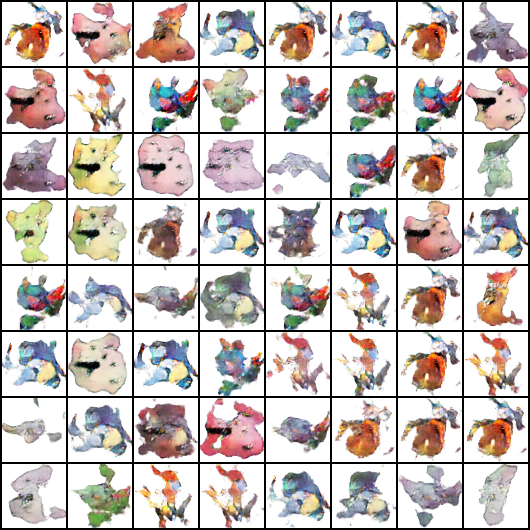

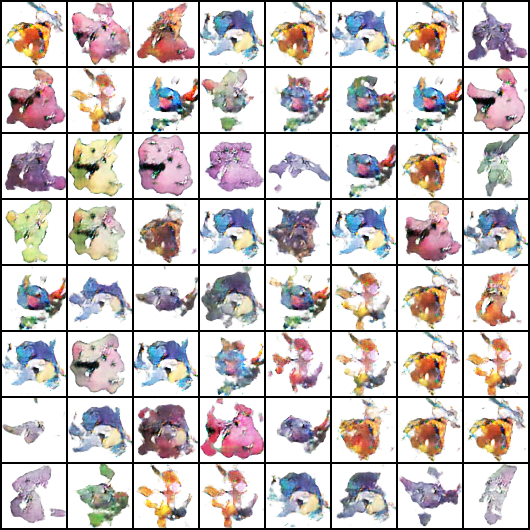

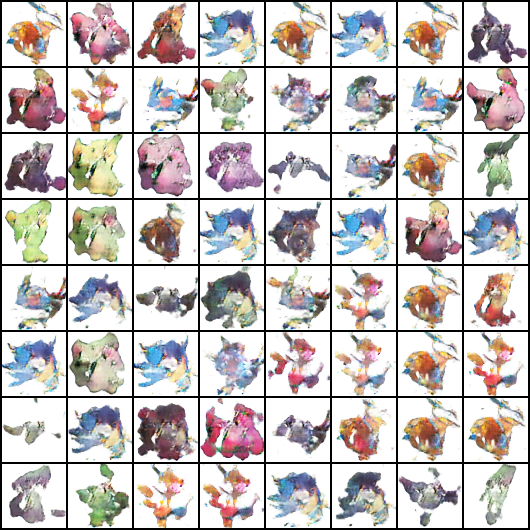

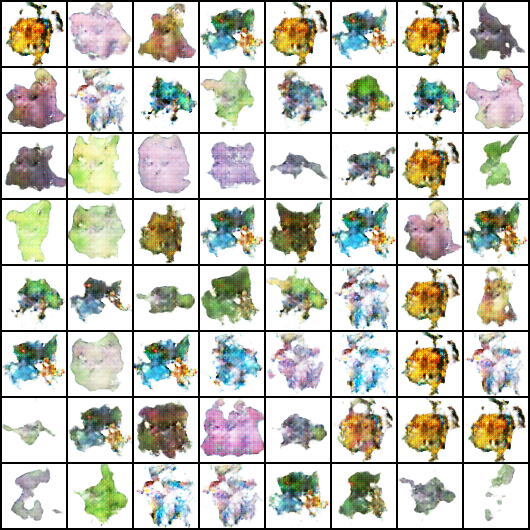

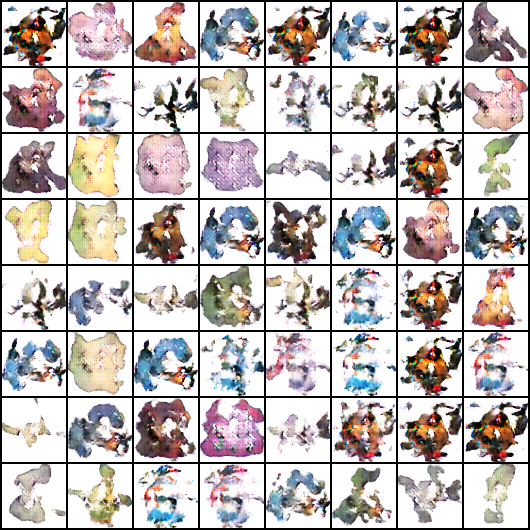

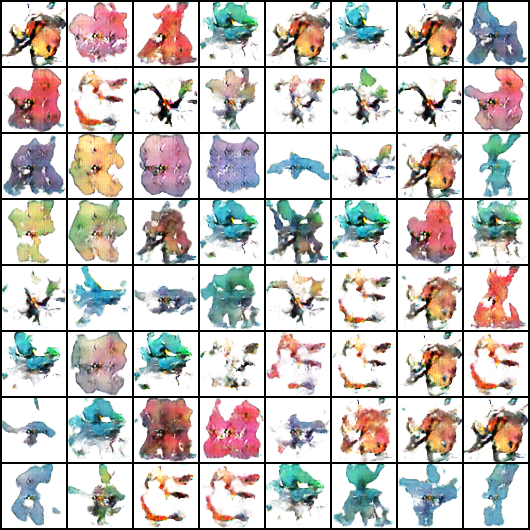

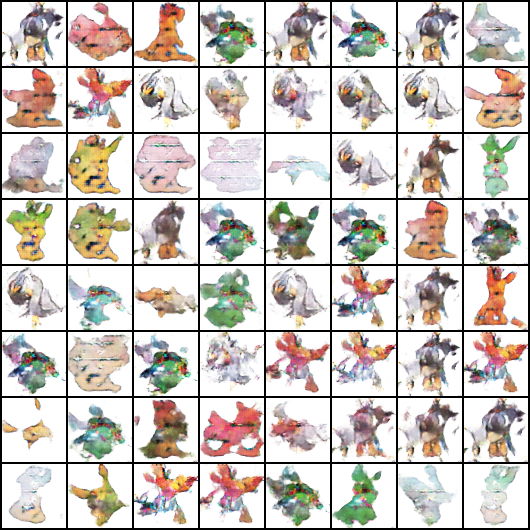

In [ ]:
vid_fname = 'Pokemon_gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

**This is how it appears:**

We can also see how the loss has progressed over time. Debugging the training process might be aided by visualizing losses. With GANs, we expect the generator's loss to decrease over time while the discriminator's loss remains relatively constant.

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Challenges faced were to run complete code in one go. Due to large computation running in colab it was tricky to run all in one go. Several times we have to abort and had to restart. Therefore then we found a code which would run the entire code in the background.

The batch size(used 20) in order to run and successfully complete training of generator and disciminator. 